In [1]:
import lbg_forecast.priors_gp_massfunc as gpmf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc


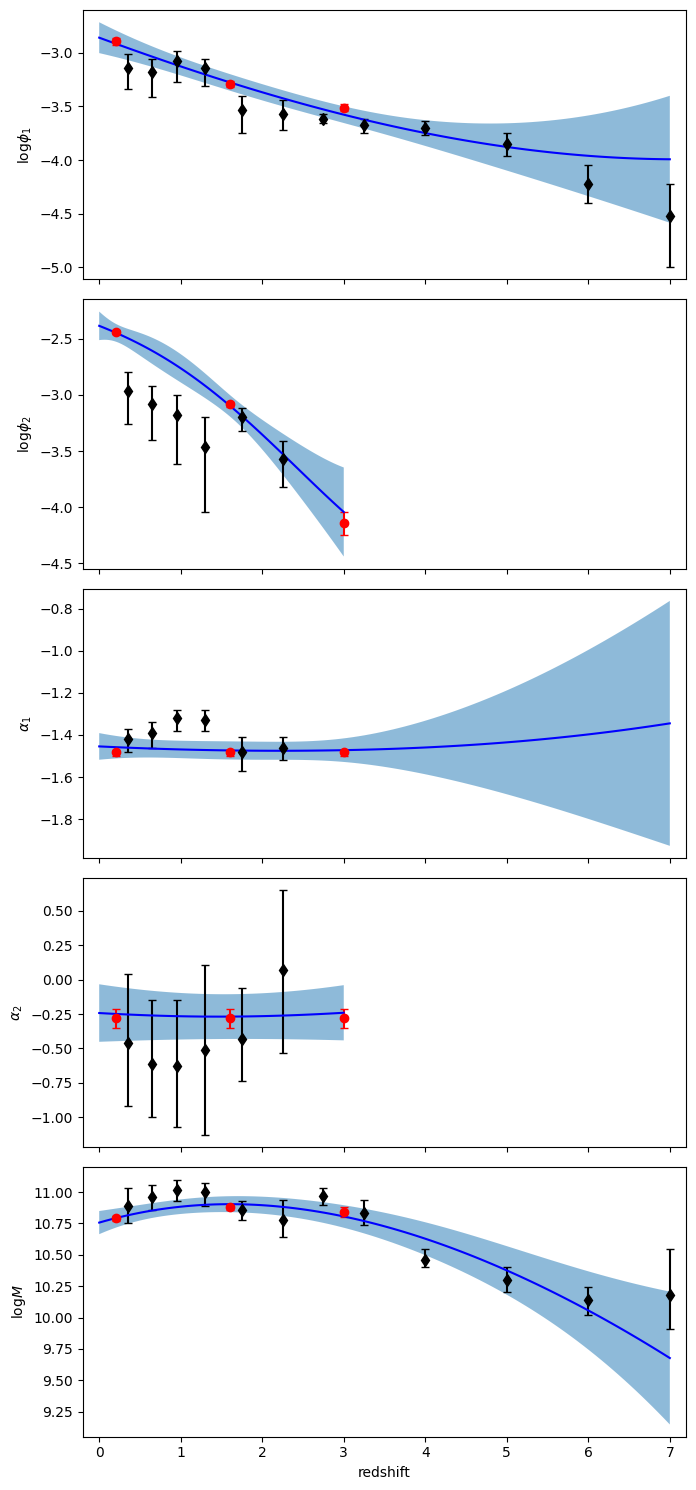

In [2]:
mass_function_prior = gpmf.MassFunctionPrior()

mass_function_prior.plot_confidence()

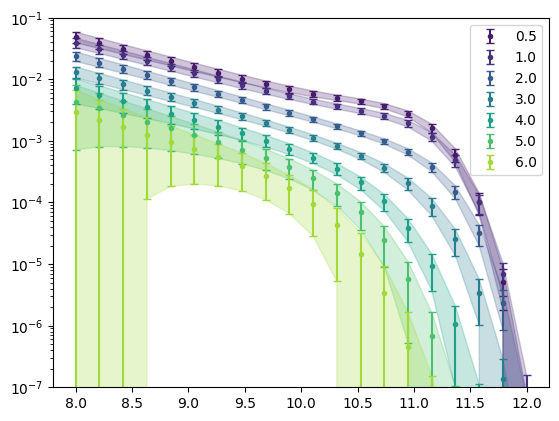

In [4]:
cmap = plt.get_cmap('viridis')
print(cmap)

redshift = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
masses = np.linspace(8, 12, 20)
nsamples = 1000
for z in redshift:
    mfunc_at_z = []
    for n in range(nsamples):
        mfunc = mass_function_prior.mass_function(z, masses, mass_function_prior.sample_prior())
        mfunc_at_z.append(mfunc)

    mfunc_at_z = np.vstack(np.array(mfunc_at_z))
    mfunc_at_z_mean = np.mean(mfunc_at_z, axis=0)
    mfunc_at_z_std = np.std(mfunc_at_z, axis=0)
    #mfunc_at_z_quantile = np.quantile(mfunc_at_z, 0.85, axis=0)
    plt.errorbar(masses, mfunc_at_z_mean, yerr=mfunc_at_z_std, color=cmap(z/7), marker="o", ls=' ', ms=3, label=str(z), capsize=3)
    plt.fill_between(masses, mfunc_at_z_mean-mfunc_at_z_std,  mfunc_at_z_mean+mfunc_at_z_std, color=cmap(z/7), alpha=0.25)
            
plt.yscale('log')
plt.ylim(1e-7, 1e-1)
plt.legend()

/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000
(505000, 2) 495000
(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000
(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


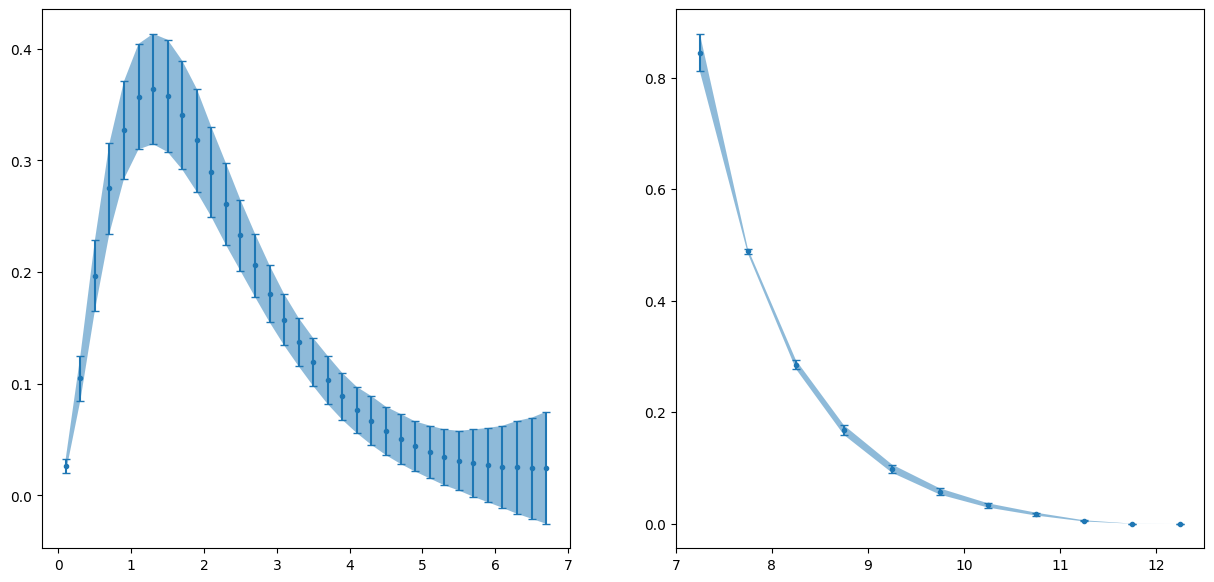

In [4]:
n_prior_samples = 20
zbins = np.arange(0.0, 7.0, 0.2)
mbins = np.arange(7, 13, 0.5)

f, ax = plt.subplots(1, 2, figsize=(15, 7))
zs=[]
ms=[]
for i in range(n_prior_samples):
    zsamples, msamples = mass_function_prior.sample_log_n()
    z_histogram = np.histogram(zsamples, bins=zbins, density=True)
    m_histogram = np.histogram(msamples, bins=mbins, density=True)

    zs.append(z_histogram[0])
    ms.append(m_histogram[0])


zs = np.vstack(np.array(zs))
ms = np.vstack(np.array(ms))
zs_mean = np.mean(zs, axis=0)
zs_std = np.std(zs, axis=0)
ax[0].errorbar((zbins[:-1]+zbins[1:])/2, zs_mean, yerr=zs_std, marker="o", ls=' ', ms=3, capsize=3)
ax[0].fill_between((zbins[:-1]+zbins[1:])/2, zs_mean-zs_std,  zs_mean+zs_std, alpha=0.5)

ms_mean = np.mean(ms, axis=0)
ms_std = 1*np.std(ms, axis=0)
ax[1].errorbar((mbins[:-1]+mbins[1:])/2, ms_mean, yerr=ms_std, marker="o", ls=' ', ms=3, capsize=3)
ax[1].fill_between((mbins[:-1]+mbins[1:])/2, ms_mean-ms_std,  ms_mean+ms_std, alpha=0.5)

/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000
(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000
(505000, 2) 495000
(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000
(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


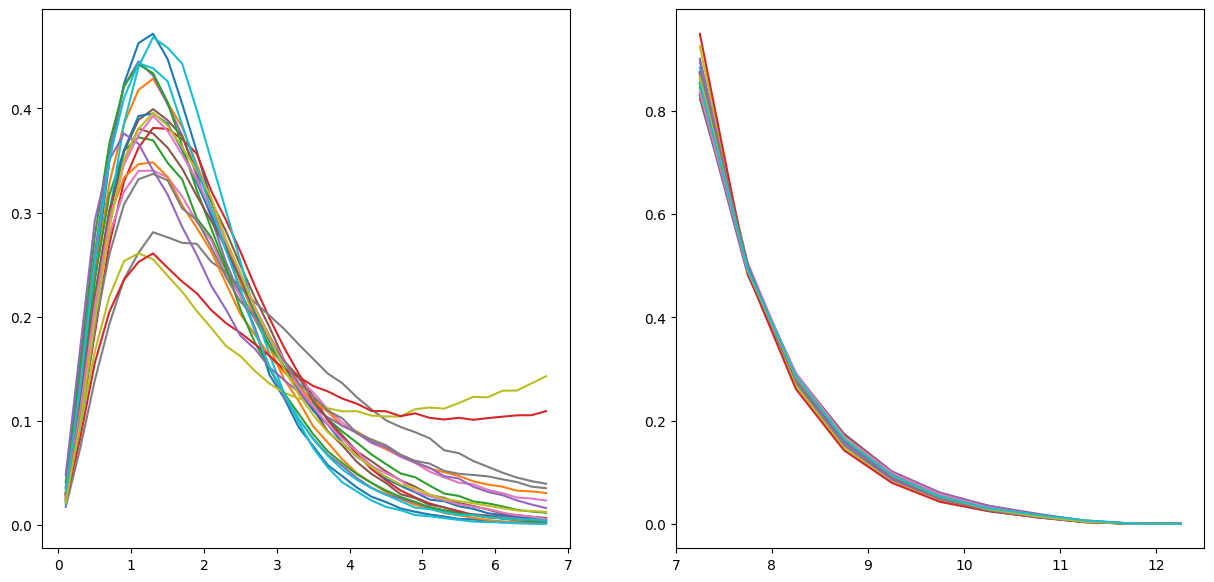

In [5]:
n_prior_samples = 20
zbins = np.arange(0.0, 7.0, 0.2)
mbins = np.arange(7, 13, 0.5)

f, ax = plt.subplots(1, 2, figsize=(15, 7))
zs=[]
ms=[]
for i in range(n_prior_samples):
    zsamples, msamples = mass_function_prior.sample_log_n()
    z_histogram = np.histogram(zsamples, bins=zbins, density=True)
    m_histogram = np.histogram(msamples, bins=mbins, density=True)

    ax[0].plot((zbins[:-1]+zbins[1:])/2, z_histogram[0])
    ax[1].plot((mbins[:-1]+mbins[1:])/2, m_histogram[0])

z_grid = np.linspace(0.0, 7.0, 50)
nsamples=10000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
selected_curves = pr.select_allowed_parameter_curves(z_grid, curves)
pr.plot_mass_function_parameter_curves(z_grid, selected_curves, log_phi_plot=False, alpha=0.1)


z_grid = np.linspace(0.0, 7.0, 50)
nsamples=1000000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
allowed_curves = pr.select_allowed_parameter_curves(z_grid, curves)

sampled_curves = pr.sample_allowed_parameter_curves(z_grid, 1000, allowed_curves)
print(sampled_curves[0].shape, sampled_curves[1].shape, sampled_curves[2].shape, sampled_curves[3].shape, sampled_curves[4].shape)
pr.plot_mass_function_parameter_curves(z_grid, sampled_curves, log_phi_plot=False, alpha=0.1)

prior_data = pr.preload_prior_data(zmax=7.0)

zsamples, logmsamples = pr.sample_redshift_mass_prior(100000, prior_data, prior_bounds=[0.0,7.0,7,13], plotting=True)